In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext memory_profiler

In [2]:
# Covariogram parameters 
L = (10, 10) 
theta = 45 * np.pi/180
var_prior = 1.0
nx = 20
ny = 20
nc = nx*ny
inp = (nx, ny, L, theta, var_prior)

In [3]:
def CalcHL(x0, x1, L, theta):
    cosT = np.cos(theta)
    sinT = np.sin(theta)
    dx = x1[0] - x0[0]
    dy = x1[1] - x0[1]
    dxRot = np.array([[cosT, -sinT], [sinT, cosT]]) @ np.array([[dx], [dy]])
    dxFlat = dxRot.flatten()
    return np.sqrt((dxFlat[0]/L[0])**2 + (dxFlat[1]/L[1])**2)


def SphereFunction(x0, x1, L, theta, var_prior):
    hl = CalcHL(x0, x1, L, theta)
    if (hl > 1):
        return 0
    return var_prior * (1.0 - 3.0/2.0*hl + (hl**3)/2)


def original(Ni, Nj, L, theta, var_prior):
    Nmatrix = Ni * Nj
    Cm = np.empty([Nmatrix, Nmatrix])
    for index0 in range(Nmatrix):
        I0 = ((index0 % Ni) + 1, (index0 // Ni) + 1)
        for index1 in range(Nmatrix):
            I1 = ((index1 % Ni) + 1, (index1 // Ni) + 1)
            Cm[index0, index1] = SphereFunction(I0, I1, L, theta, var_prior)
    return Cm

In [4]:
def vectorized(Ni, Nj, L, theta, var_prior):
    cosT = np.cos(theta)
    sinT = np.sin(theta)
    Nmatrix = Ni * Nj
    index = np.arange(Nmatrix)  # 1D-index
    I = index % Ni + 1  # 2D-indices
    J = index // Ni + 1
    I0, I1 = np.meshgrid(I, I)
    J0, J1 = np.meshgrid(J, J)
    dx = I1 - I0
    dy = J1 - J0
    # rotate
    dxRot = cosT * dx - sinT * dy
    dyRot = sinT * dx + cosT * dy
    # norm
    hl = np.sqrt((dxRot/L[0])**2 + (dyRot/L[1])**2)
    Cm = var_prior * (1.0 - 3.0 / 2.0 * hl + (hl ** 3) / 2)
    Cm[hl > 1] = 0
    return Cm

In [5]:
def fullmatrix(nx, ny, length, theta, var_prior):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)

    # Fill the first row nx * nc
    tmp = np.zeros([nx, nc])
    for i in range(nx):
        for j in range(i+1, nc):
            d0 = j % nx - i
            d1 = j // nx
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1
            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)

            # Calculate value.
            if hl <= 1:
                tmp[i, j] = var_prior * (1 - 3/2*hl + (hl**3)/2)

    # Fill the upper triangle by copying the first row
    cov = np.zeros([nc, nc])
    for j in range(ny):
        cov[nx*j:nx*(j+1), nx*j:] = tmp[:, :nc-nx*j]

    # Add the diagonal
    cov += np.diag(np.ones(nc))

    return cov.T

In [6]:
def sparsematrix(nx, ny, length, theta, var_prior, dtype='float32'):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    # 1. Fill the first row nx * nc, but vertically
    tmp1 = np.zeros([nx, nc], dtype=dtype)
    for i in range(nx):
        tmp1[i, 0] = 1.0  # diagonal
        for j in range(i+1, nc):
            d0 = (j % nx) - i
            d1 = (j // nx)
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1
            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)
            if hl <= 1:
                tmp1[i, j-i] = var_prior * (1 - 1.5*hl + hl**3/2)  

    # 2. Get the indices of the non-zero columns
    ind = np.where(tmp1.sum(axis=0))[0]

    # 3. Expand the non-zero colums ny-times
    tmp2 = np.zeros([nc, ind.size], dtype=dtype)
    for i, j in enumerate(ind):
        n = j//nx
        tmp2[:nc-n*nx, i] = np.tile(tmp1[:, j], ny-n)

    # 4. Construct array through sparse diagonal array
    cov = sp.sparse.dia_array((tmp2.T, -ind), shape=(nc, nc))
    return cov.toarray()

Identical :: original == vectorized    :: True
             original == full matrix   :: True
             original == sparse matrix :: True



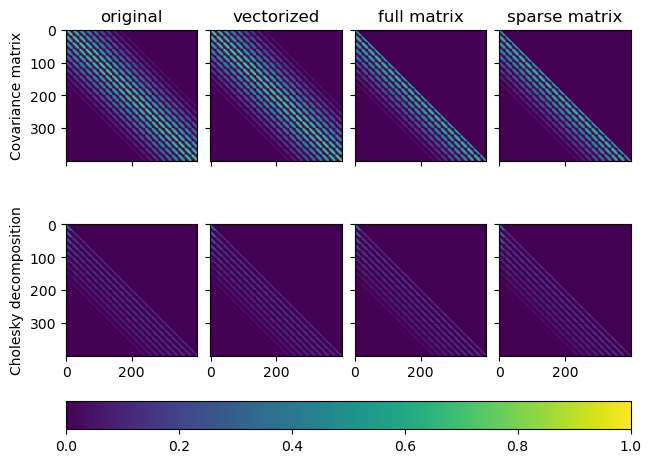

In [7]:
orig = original(*inp)
vect = vectorized(*inp)
full = fullmatrix(*inp)
spar = sparsematrix(*inp, dtype='float64')
# float32 is sufficient, but for the equality check we run with 64

corig = sp.linalg.cholesky(orig, True)
cvect = sp.linalg.cholesky(vect, True)
cfull = sp.linalg.cholesky(full, True)
cspar = sp.linalg.cholesky(spar, True)

print(f"Identical :: original == vectorized    :: {np.allclose(corig, cvect)}\n",
      f"            original == full matrix   :: {np.allclose(corig, cfull)}\n",
      f"            original == sparse matrix :: {np.allclose(corig, cspar)}\n")


fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True)
axs[0, 0].set_title('original')
axs[0, 1].set_title('vectorized')
axs[0, 2].set_title('full matrix')
axs[0, 3].set_title('sparse matrix')

axs[0, 0].set_ylabel('Covariance matrix')
im = axs[0, 0].imshow(orig, aspect='equal', vmin=0, vmax=1)
axs[0, 1].imshow(vect, aspect='equal', vmin=0, vmax=1)
axs[0, 2].imshow(full, aspect='equal', vmin=0, vmax=1)
axs[0, 3].imshow(spar, aspect='equal', vmin=0, vmax=1)

axs[1, 0].set_ylabel('Cholesky decomposition')
axs[1, 0].imshow(corig, aspect='equal', vmin=0, vmax=1)
axs[1, 1].imshow(cvect, aspect='equal', vmin=0, vmax=1)
axs[1, 2].imshow(cfull, aspect='equal', vmin=0, vmax=1)
axs[1, 3].imshow(cspar, aspect='equal', vmin=0, vmax=1)

fig.colorbar(im, ax=axs, orientation='horizontal');

## Runtime and memory

We choose a bigger model for this, to see the difference more clearly.

In [8]:
inp = (60, 60, L, theta, var_prior)

In [9]:
%timeit original(*inp)
%timeit vectorized(*inp)
%timeit fullmatrix(*inp)
%timeit sparsematrix(*inp)

55.9 s ± 717 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
477 ms ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
238 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
197 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%memit original(*inp)
%memit vectorized(*inp)
%memit fullmatrix(*inp)
%memit sparsematrix(*inp)

peak memory: 254.66 MiB, increment: 98.72 MiB
peak memory: 1195.83 MiB, increment: 1039.80 MiB
peak memory: 187.75 MiB, increment: 31.50 MiB
peak memory: 171.78 MiB, increment: 15.52 MiB
